<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/345_bayesian_prediction.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(bayesian_prediction_notebook)=
# La predizione bayesiana 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import statistics
import seaborn as sns
from scipy.stats import betabinom, beta, binom
import pymc as pm
import xarray as xr
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

L'analisi bayesiana si pone diversi obiettivi, tra cui la sintesi della distribuzione a posteriori dei parametri, la verifica di ipotesi e la predizione di nuovi dati futuri. Dopo aver osservato i dati di un campione e aver ottenuto le distribuzioni a posteriori dei parametri, è possibile fare delle previsioni sulle proprietà di dati futuri. Una delle applicazioni più immediate di questa stima è la verifica del modello, poiché il modo più diretto per testare un modello è quello di utilizzare il modello corrente per fare previsioni sui possibili dati futuri e poi confrontare questi dati predetti con i dati effettivamente osservati nel campione corrente. Questo processo è chiamato *controllo predittivo a posteriori*.

In questo capitolo ci concentreremo sul problema della predizione bayesiana, partendo dal caso più semplice, ovvero lo schema beta-binomiale, per poi estendere la discussione al caso generale. In sostanza, l'obiettivo è di utilizzare l'informazione a priori e a posteriori sui parametri del modello per fare previsioni sulle proprietà dei dati futuri, fornendo così un metodo utile per la verifica del modello e per il supporto alle decisioni.

## La distribuzione predittiva a posteriori

Dopo aver costruito la distribuzione a posteriori dei parametri sconosciuti, un'analisi inferenziale bayesiana può essere utilizzata per fare previsioni sui possibili risultati futuri, dando origine all'analisi predittiva. Nel caso specifico del modello beta-binomiale, la distribuzione a priori del parametro $\theta$ (probabilità di successo) è una distribuzione Beta, la verosimiglianza è binomiale e i dati consistono nel numero $y$ di successi in $n$ prove Bernoulliane indipendenti.

Nell'esempio che andremo a esaminare, utilizzeremo ancora i dati del campione di pazienti clinici depressi di {cite:t}`zetsche_2019future`. Immaginiamo di voler esaminare in futuro un altro gruppo di $m$ pazienti clinici e ci chiediamo quanti di essi potrebbero manifestare una depressione grave. Supponiamo di voler fare previsioni sui risultati di nuovi campioni di $m=30$ osservazioni. Indichiamo con $\tilde{Y}$ la variabile casuale che rappresenta il numero di pazienti con depressione grave in un nuovo campione di $m$ pazienti clinici. Quindi, in un nuovo campione, $\tilde{Y}$ potrebbe assumere un valore $\tilde{y}_1$ (ad esempio 12), un altro campione potrebbe produrre un valore $\tilde{y}_2$ (ad esempio 23) e così via. Vogliamo calcolare le probabilità di osservare ciascuno dei valori $\tilde{Y}$ compresi tra $0$ e $30$ inclusi. Questa distribuzione di massa di probabilità è chiamata *distribuzione predittiva a posteriori*, $p(\tilde{Y} = \tilde{y} \mid Y = y)$. Essa rappresenta la probabilità assegnata a ciascuno dei possibili valori $\tilde{Y}$ ($0, 1, 2, \dots, 29, 30$) nei possibili campioni futuri di $m$ pazienti clinici.

In questo capitolo ci concentreremo sull'individuazione della distribuzione predittiva a posteriori nel contesto del modello beta-binomiale. Esploreremo tre diverse metodologie per raggiungere questo obiettivo:

- L'approccio analitico, che prevede la risoluzione della distribuzione in modo matematico.
- L'utilizzo della simulazione.
- L'impiego della tecnica del campionamento MCMC per stimare la distribuzione predittiva a posteriori.

I tre metodi sono equivalenti e producono gli stessi risultati. Tuttavia, in seguito utilizzeremo il metodo MCMC perché ci permette di ottenere la soluzione desiderata in modo semplice, anche quando non è disponibile una soluzione analitica.

## Soluzione analitica

Nel caso dell'esempio in discussione, la distribuzione di $\tilde{Y}$ dipende da $\theta$ e ciò che sappiamo di $\theta$ è sintetizzato nella distribuzione a posteriori $p(\theta \mid y)$. Usando la regola della catena, possiamo scrivere la distribuzione congiunta di $\tilde{y}$ e $\theta$ nel modo seguente

$$
p(\tilde{y}, \theta \mid y) = p(\tilde{y} \mid \theta, y) p(\theta \mid y).
$$

Assumendo che le osservazioni future $\tilde{y}$ e passate $y$ siano condizionalmente indipendenti dato $\theta$, l'espressione precedente può essere scritta come

$$
p(\tilde{y}, \theta \mid y) = p(\tilde{y} \mid \theta) p(\theta \mid y).
$$

La distribuzione predittiva a posteriori viene ottenuta dalla distribuzione congiunta di $\tilde{y}$ e $\theta$ integrando rispetto a $\theta$:

$$
p(\tilde{y} \mid y) = \int_{\theta} p(\tilde{y} \mid \theta) p(\theta \mid y) \,\operatorname {d}\!\theta.
$$ (eq-post-pred-distr)

Nel caso dello schema beta-binomiale, la funzione $p(\tilde{y} \mid \theta)$ è binomiale di parametri $m$ e $\theta$, e la distribuzione a posteriori $p(\theta \mid y)$ è una $Beta(\alpha + y, \beta + n - y)$. Risolvendo l'integrale otteniamo:

$$
\begin{align}
p(\tilde{y} \mid y) &= \int_0^1 p(\tilde{y} \mid \theta)
p(\theta \mid y)\,\operatorname {d}\!\theta \notag\\
 &= \int_0^1 \begin{pmatrix}m\\\tilde{y}\end{pmatrix}
 \theta^{\tilde{y}}
(1-\theta)^{m-\tilde{y}} \, Beta(a+y,b+n-y) \, d\theta \notag\\
&= \begin{pmatrix}{m}\\\tilde{y}\end{pmatrix} \int_0^1 \theta^{\tilde{y}}
(1-\theta)^{m-\tilde{y}} \frac{1}{B(a+y, b+n-y)}\theta^{a+y-1}(1-\theta)^{b+n-y-1} \, d\theta \notag\\
&= \begin{pmatrix}{ m }\\\tilde{y}\end{pmatrix} \frac{1}{B(a+y, b+n-y)}\int_0^1 \theta^{\tilde{y}+a+y-1}(1-\theta)^{m-\tilde{y}+b+n-y-1} \, d\theta\notag\\
&= \begin{pmatrix}{ m }\\\tilde{y}\end{pmatrix} \frac{B(\tilde{y}+a+y,b+n-y+m-\tilde{y})}{B(a+y, b+n-y)} \; .
\end{align}
$$ (eq-post-yprime-an-sol-betabin)

In conclusione, per lo schema beta-binomiale, la distribuzione predittiva a posteriori corrisponde ad una distribuzione di probabilità discreta chiamata *distribuzione beta-binomiale* di parametri $m$, $\alpha+y$ e $\beta+n-y$.

$$
f(\tilde{y} \mid y) = \binom{m}{\tilde{y}} \frac{B(a+ y + \tilde{y}, b + n - y + m - \tilde{y})}{B(a+y, b+n-y)},
$$ (eq-beta-binomial-distr)

Nell'esempio relativo allo studio di {cite:t}`zetsche_2019future`, la verosimiglianza è binomiale, i dati sono costituiti da 23 successi su 30 prove e la distribuzione a priori su $\theta$ è una Beta(2, 10). Di conseguenza, la distribuzione a posteriori è una Beta(25, 17). Vogliamo calcolare la distribuzione predittiva a posteriori per un nuovo campione, poniamo, di $m = 30$ osservazioni (ma, in generale, $m$ può essere diverso da $n$).

In base all'eq. {eq}`eq-beta-binomial-distr` sappiamo che la distribuzione predittiva a posteriori è una distribuzione beta-binomiale di parametri $m$, $\alpha+y$ e $\beta+n-y$, dove $m$ è il numero di prove nel nuovo campione, $\alpha$ e $\beta$ sono i parametri della distribuzione a priori, e $y$ e $n$ sono le proprietà del campione corrente. Nel caso dell'esempio in discussione, $m = 30$, $\alpha = 2 + 23 = 25$, $\beta = 10 + 30 - 23 = 17$. 

Utilizziamo Python per rappresentare la distribuzione predittiva a posteriori che abbiamo definito mediante la funzione `betabinom.pmf`.

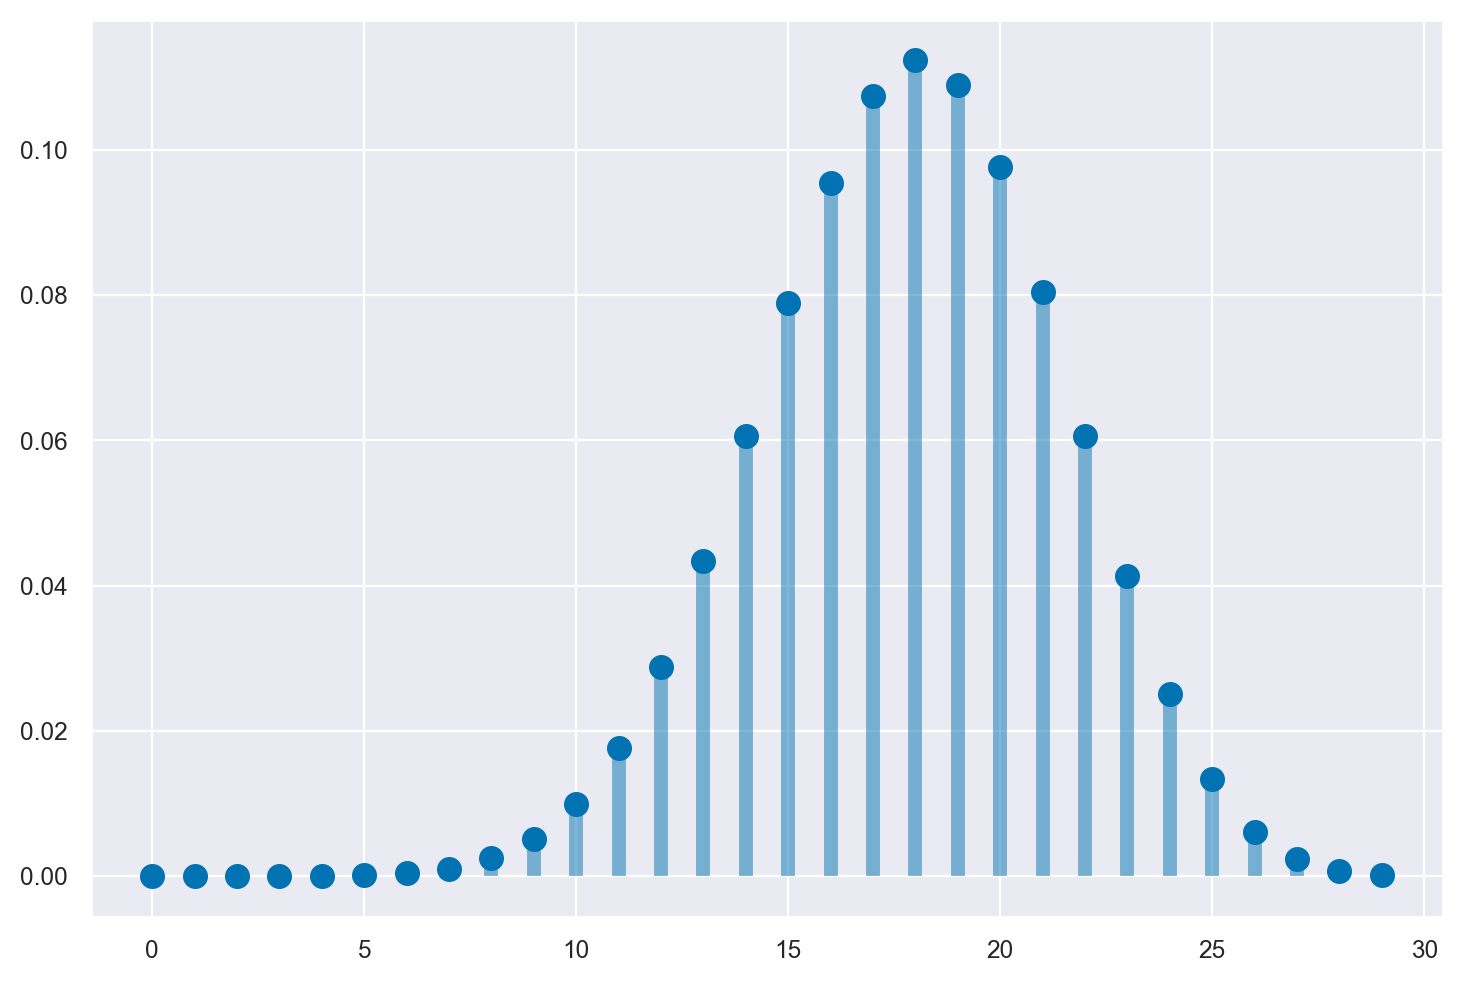

In [3]:
n = 30
a = 25
b = 17

x = np.arange(0, 30)
plt.plot(x, betabinom.pmf(x, n, a, b), "bo", ms=8, label="betabinom pmf")
_ = plt.vlines(x, 0, betabinom.pmf(x, n, a, b), colors="b", lw=5, alpha=0.5)

La distribuzione predittiva a posteriori illustrata nella figura precedente ci dice qual è la credibilità relativa di osservare $0, 1, \dots, 30$ successi su $m = 30$ prove in un futuro campione di osservazioni, alla luce dei dati che abbiamo osservato nel campione corrente (23 successi in 30 prove) e tenuto conto delle nostre opinioni a priori sulla plausibilità dei possibili valori $\theta$ (ovvero, Beta(2, 10)).

Esaminando la distribuzione predittiva notiamo che, nei possibili campioni futuri di 30 osservazioni, il valore $\tilde{y}$ più plausibile è 18. Tuttavia, $\tilde{y}$ può assumere anche altri valori e la distribuzione predittiva ci informa sulla *credibilità relativa* di ciascuno dei possibili valori futuri $\tilde{y}$ -- nel presente esempio, $\tilde{y}$ corrisponde al numero di pazienti clinici (su 30) che manifestano una depressione grave.

È desiderabile costruire un intervallo che contiene le realizzazioni $\tilde{y}$ ad un livello specificato di probabilità. Supponiamo che il livello di probabilità richiesto sia 0.89. L'intervallo si costruisce aggiungendo valori $\tilde{y}$ all'intervallo (partendo da quello con la probabilità maggiore) fino a che il contenuto di probabilità dell'insieme eccede la soglia richiesta, nel caso presente di 0.89.

Sulla base delle informazioni disponibili, possiamo dunque prevedere, con un livello di certezza soggettiva che eccede la soglia di 0.91, che in un futuro campione di 30 soggetti clinici depressi, il numero di pazienti con depressione grave sarà compreso tra 12 e 23.

$$
P(12 \leq \tilde{y} \leq 23) = 0.9145.
$$

In [4]:
x_set = np.arange(12, 24)
betabinom.pmf(x_set, n, a, b).sum()

0.9152884954868495

In conclusione, per il caso beta-binomiale, possiamo concludere che la predizione bayesiana di una nuova osservazione futura è la realizzazione di una distribuzione beta-binomiale di parametri $m$, $\alpha + y$, e $\beta + n - y$, dove $m$ è il numero di prove nel nuovo campione, $\alpha$ e $\beta$ sono i parametri della distribuzione a priori, e $y$ e $n$ sono le caratteristiche del campione.

## La distribuzione predittiva a posteriori mediante simulazione

In situazioni in cui non è possibile ottenere l'esatta distribuzione predittiva a posteriori, è comunque possibile ottenere un campione casuale di valori dalla distribuzione mediante simulazione. Nel caso che stiamo discutendo, supponiamo di volere ottenere un campione casuale di $n$ osservazioni dalla distribuzione predittiva a posteriori. Per fare ciò, possiamo svolgere la simulazione in due fasi:

- estraiamo $n$ valori casuali del parametro $\theta$ dalla distribuzione a posteriori $p(\theta \mid y)$;
- usiamo i valori del parametro $\theta$ estratti per generare $n$ valori casuali $\tilde{y}$, utilizzando il modello binomiale con i parametri $m$ e $\theta_i$ (con $i = 1, \dots, n$).

In questo modo otteniamo $n$ realizzazioni casuali di $n$ distribuzioni binomiali, ciascuna con i parametri specificati sopra, che rappresentano un campione casuale di valori della distribuzione predittiva a posteriori.

Vediamo come questo risultato possa essere ottenuto in pratica. Per l'esempio che stiamo discutendo, la distribuzione a posteriori di $\theta$ è una Beta(25, 17). Estraiamo 100,000 valori a caso da tale distribuzione e ne stampiamo i primi 10:

In [5]:
nrep = 100000
theta = beta.rvs(a, b, size=nrep)
print(*theta[0:10])

0.4186794228323471 0.6280820580315606 0.660048141210776 0.6166308437708264 0.6746022724159161 0.5881042113740296 0.6338435092790788 0.7270233405856397 0.6570783957244968 0.4272537390914828


Per ciascuno di questi 100,000 valori $\theta$ estraggo a caso un valore dalla distribuzione binomiale di parametri $n = 30$ e probabilità $\theta$. Stampo qui di seguito i primi 10 valori così trovati.

In [6]:
pred_y_sim = [binom.rvs(n=30, p=th, size=1) for th in theta]
pred_y_sim = np.concatenate(pred_y_sim)
print(*pred_y_sim[0:10])

7 18 23 17 22 22 21 22 15 11


L'insieme dei valori `pred_y_sim` costituisce un campione casuale dalla distribuzione predittiva a posteriori. Qui di seguito è mostrata una figura che riporta i risultati della simulazione (l'istogramma dei valori `pred_y_sim`). All'istogramma sono sovrapposti i punti della corretta distribuzione a posteriori corrispondente ad una distribuzione Beta-Binomiale di parametri n = 30, a = 25, b = 17. Si noti la corrispondenza tra i valori ottenuti mediante la simulazione e i valori teorici.

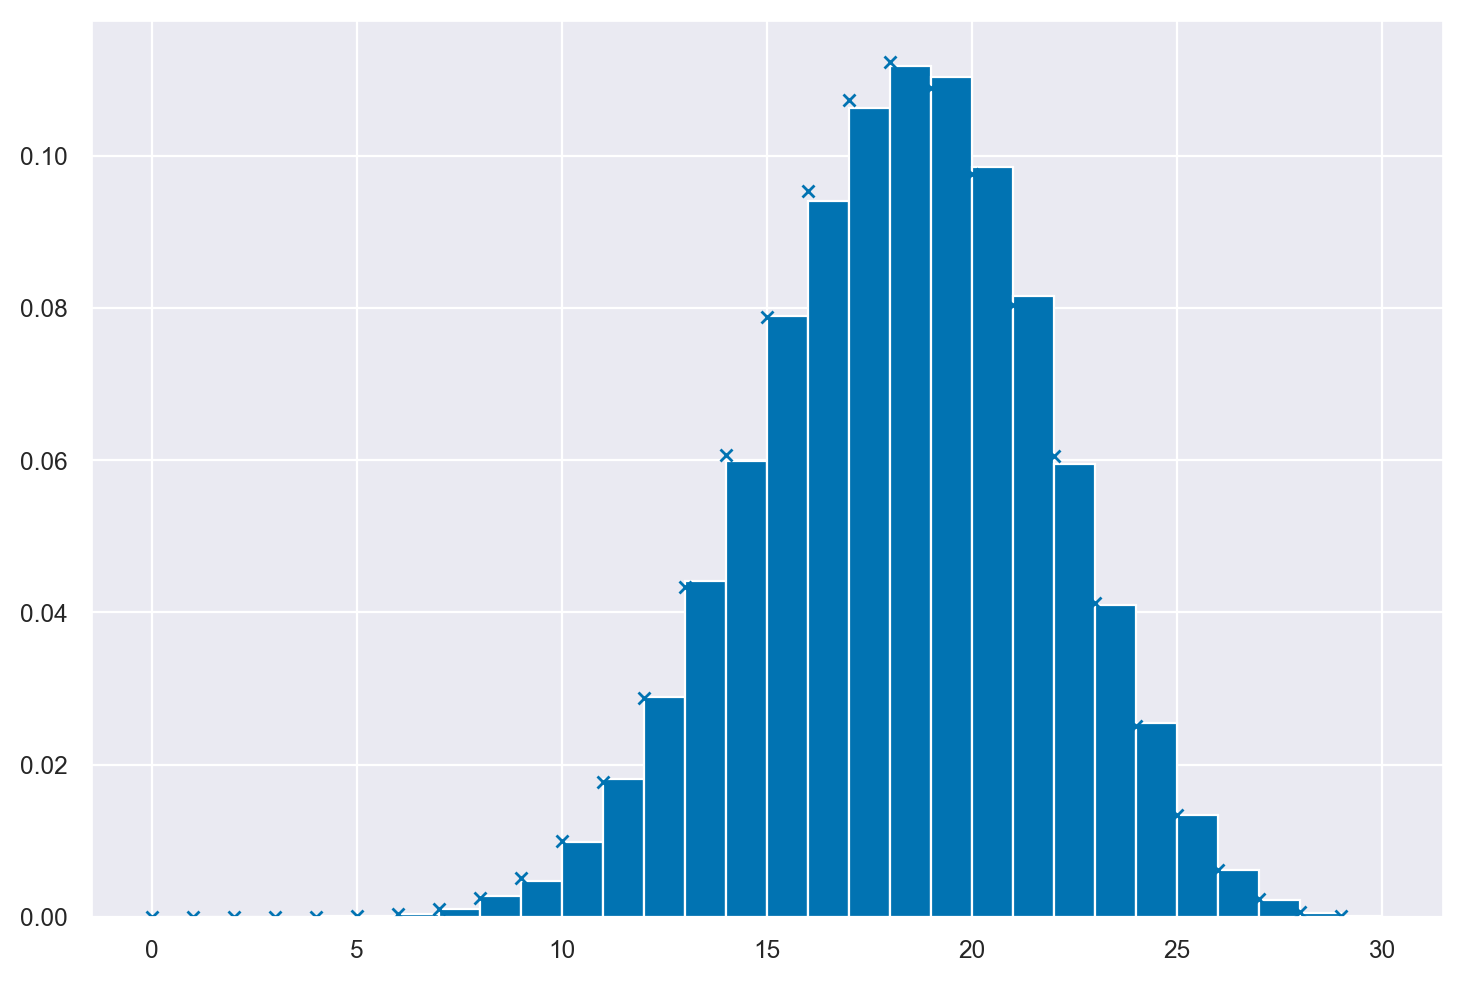

In [7]:
counts = plt.hist(pred_y_sim, bins=np.arange(0, 31), density=True)
_ = plt.plot(x, betabinom.pmf(x, n, a, b), "bx", ms=4, label="betabinom pmf")

## La distribuzione predittiva a posteriori mediante MCMC

Il metodo basato su simulazione che abbiamo discusso sopra si basa sulla stessa logica che i metodi MCMC usano per ottenere un'approssimazione della distribuzione predittiva a posteriori. Mediante i metodi MCMC, le stime delle possibili osservazioni future $p(\tilde{y} \mid y)$, chiamate $p(y^{rep} \mid y)$, si ottengono nel modo seguente:

-   campionare $\theta_i \sim p(\theta \mid y)$, ovvero scegliere un valore a caso del parametro dalla distribuzione a posteriori;
-   campionare $y^{rep} \sim p(y^{rep} \mid \theta_i)$, ovvero scegliere un'osservazione a caso dalla funzione di verosimiglianza condizionata al valore del parametro definito nel passo precedente.

Se i due passaggi descritti sopra vengono ripetuti un numero sufficiente di volte, l'istogramma risultante approssimerà la distribuzione predittiva a posteriori che, in alcuni casi, può essere ottenuta per via analitica (come nell'esempio presente).

Eseguiamo il campionamento MCMC per i dati dell'esempio.

In [8]:
ntrials = 30
y = 23

alpha_prior = 2
beta_prior = 10

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)
    idata = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 49 seconds.


Esaminiamo la distribuzione a posteriori.

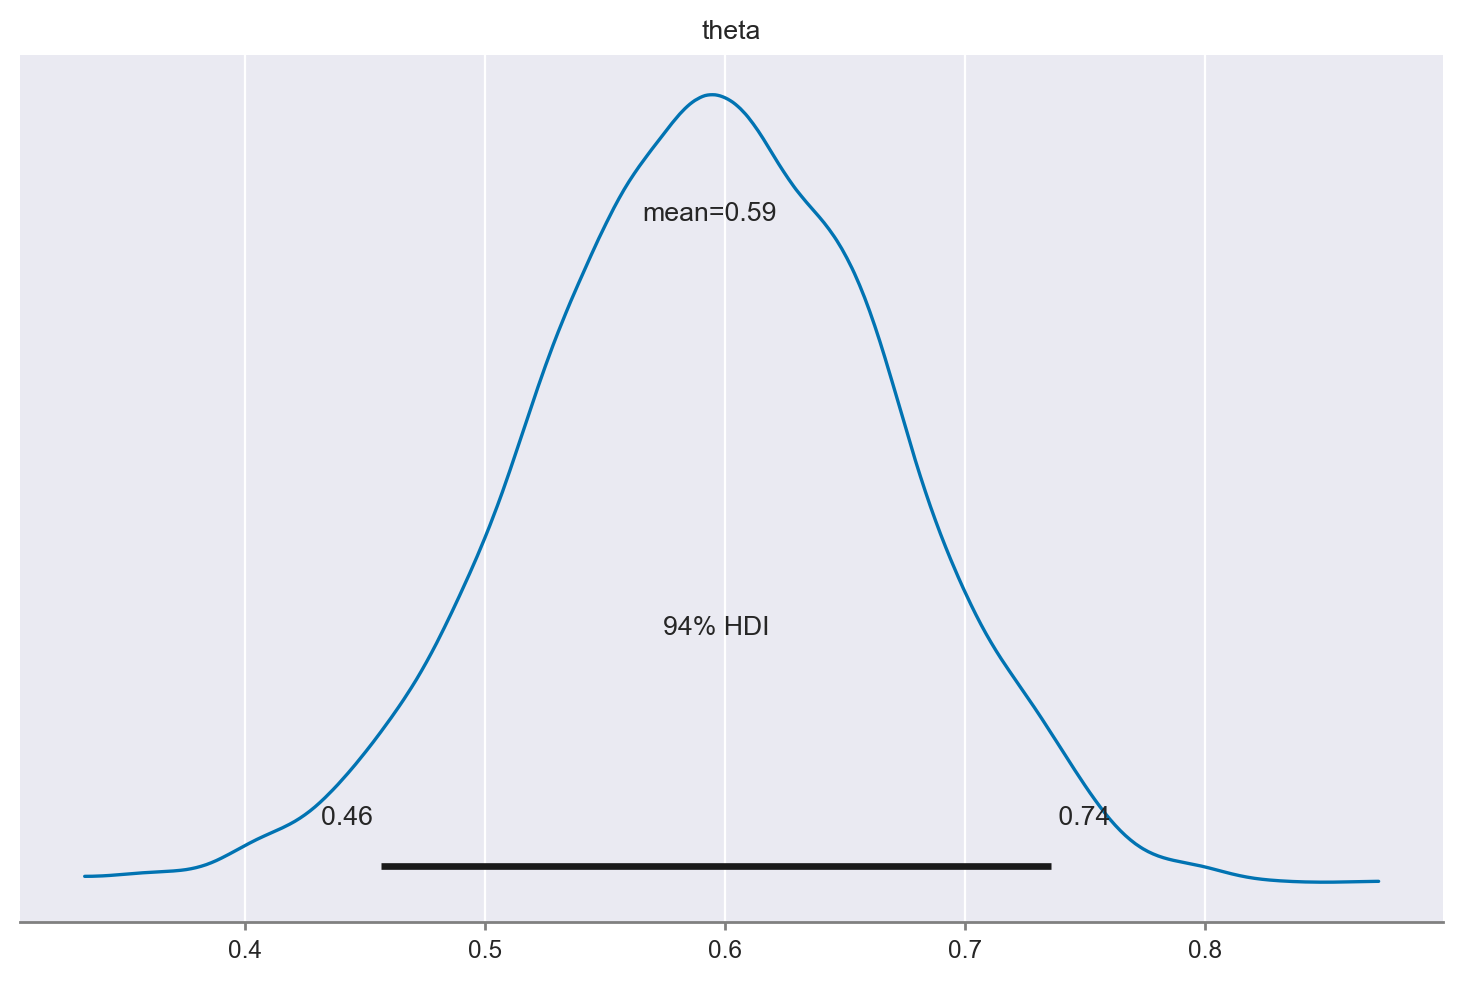

In [9]:
_ = az.plot_posterior(idata.posterior.theta)

Creiamo un campione di osservazioni predittive a posteriori, $y^{rep} \sim p(y^{rep} \mid \theta_i)$.

In [10]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs]


Esaminiamo i dati ottenuti.

In [11]:
post_pred.posterior_predictive.obs

<xarray.DataArray 'obs' (chain: 4, draw: 2000)>
array([[12, 21, 13, ..., 11, 15, 17],
       [24, 21, 17, ..., 17, 19, 15],
       [22, 20, 18, ..., 21, 15, 20],
       [12, 16, 12, ..., 21, 16, 21]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

Creiamo un istogramma con i dati $y^{rep}$. Si noti che il risultato riproduce ciò che abbiamo ottenuto in precedenza per via analitica e tramite simulazione. L'intervallo di credibilità del 91% è, anche in questo caso, pari a [12, 23].

<Axes: title={'center': 'obs'}>

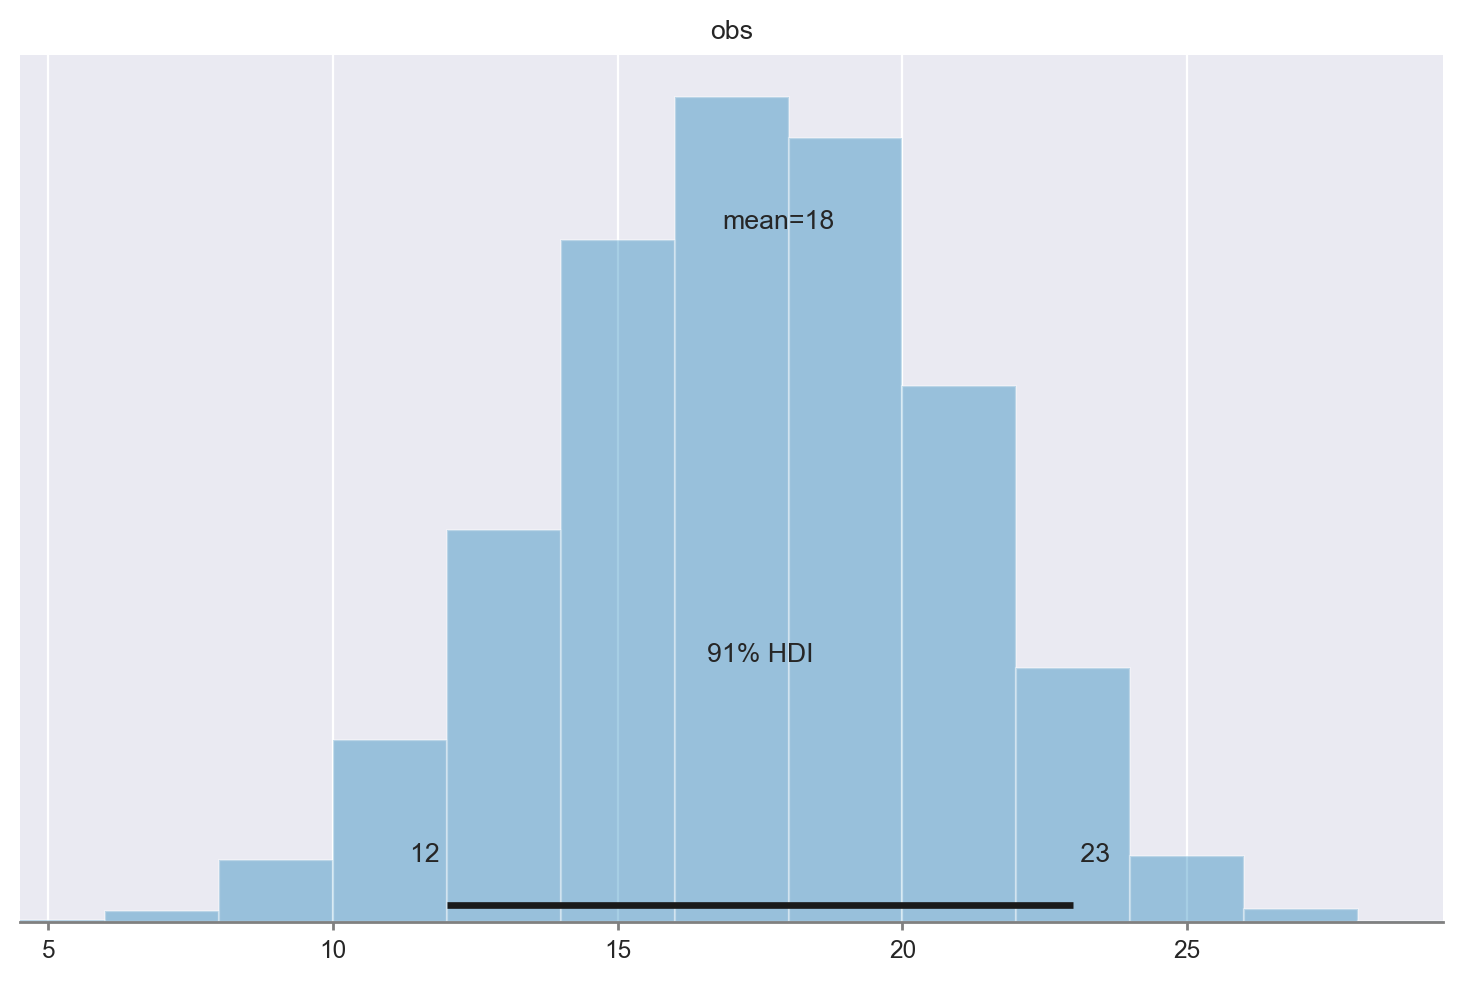

In [12]:
az.plot_posterior(post_pred.posterior_predictive.obs, hdi_prob=0.91)

### Posterior predictive checks

La distribuzione predittiva a posteriori viene utilizzata per eseguire i cosiddetti *controlli predittivi a posteriori* (*Posterior Predictive Checks*, PPC). I PPC eseguono un confronto grafico tra $p(y^{rep} \mid y)$ e i dati osservati $y$: confrontando visivamente gli aspetti chiave dei dati previsti futuri $y^{rep}$ e dei dati osservati $y$ è possibile determinare se il modello è adeguato.

Oltre al confronto visivo tra le distribuzioni $p(y)$ e $p(y^{rep})$ è anche possibile un confronto tra la distribuzione di varie statistiche descrittive, i cui valori sono calcolati su diversi campioni $y^{rep}$, e le corrispondenti statistiche calcolate sui dati osservati. Vengono solitamente considerate statistiche descrittive quali la media, la varianza, la deviazione standard, il minimo o il massimo, ma sono possibili confronti di questo tipo per qualunque altra statistica.

## Distribuzione predittiva a priori

Nella sezione precedente abbiamo visto come la distribuzione predittiva viene usata per generare nuovi dati previsti futuri. Più precisamente, mediante l'eq. {eq}`eq-post-pred-distr` abbiamo descritto la nostra incertezza sulla distribuzione di future osservazioni di dati, data la distribuzione a posteriori di $\theta$, ovvero tenendo conto della scelta del modello e della stima dei parametri mediante i dati osservati:

$$
p(\tilde{y} \mid y) = \int_{\theta} p(\tilde{y} \mid \theta) p(\theta \mid y) \,\operatorname {d}\!\theta\notag
$$

Si noti che, nell'eq. {eq}`eq-post-pred-distr`, $\tilde{y}$ è condizionato da $y$ ma non da ciò che è incognito, ovvero $\theta$: la distribuzione predittiva a posteriori è ottenuta mediante marginalizzazione sopra i parametri incogniti $\theta$.

In un modello bayesiano dove $\theta$ ha una distribuzione a priori $p(\theta)$ e per $y$ possiamo definire la funzione di verosimiglianza $p(y \mid \theta)$, è possibile scrivere la distribuzione congiunta $p(y, \theta)$ come il prodotto della verosimiglianza e della distribuzione a priori:

$$
p(y, \theta) = p(y \mid \theta)p(\theta).
$$

Una rappresentazione alternativa della distribuzione congiunta $p(y, \theta)$ è

$$
p(y, \theta) = p(\theta \mid y)p(y).
$$

Il primo termine in questo prodotto, la densità $p(\theta \mid y)$, è la densità a posteriori di $\theta$ date le osservazioni $y$. Il secondo termine in questo prodotto, $p(y)$, è la *distribuzione predittiva a priori* che rappresenta la distribuzione dei dati futuri previsti dal modello prima di avere osservato il campione $y$. Se risulta che i dati osservati $y$ non sono coerenti con la distribuzione predittiva a priori, ciò significa che il modello bayesiano non è specificato correttamente. In altre parole, questo ci dice che, in base al modello bayesiano che abbiamo formulato, è improbabile che si verifichino i dati che sono stati effettivamente osservati. Ovviamente, questo vuol dire che il modello è inadeguato.

La distribuzione predittiva a priori può essere ricavata facilmente se l'inferenza bayesiana viene svolta mediante i metodi MCMC e viene usata per verificare l'adeguatezza della formulazione del modello.

Nella discussione dell'analisi dei dati di {cite}`zetsche_2019future`, la $Beta(2, 10)$ è stata utilizzata quale distribuzione a priori solo per evidenziare le proprietà dell'aggiornamento bayesiano (ovvero, la differenza tra distribuzione a priori e distribuzione a posteriori). Calcolando la distribuzione predittiva a priori è facile rendersi conto che la $Beta(2, 10)$ non è una buona scelta per i dati considerati. 

Per svolgere l'analisi predittiva a priori, usiamo la funzione `pm.sample_prior_predictive()`.

In [13]:
ntrials = 16
y = 14

alpha_prior = 2
beta_prior = 10

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)
    idata = pm.sample_prior_predictive(samples=2000, random_seed=rng)

Sampling: [obs, theta]


In [14]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

I dati (sulla scala delle osservazioni $y$) sono contenuti in `idata.prior_predictive.obs`. Uso `arviz` per generare un istogramma:

<Axes: title={'center': 'obs'}>

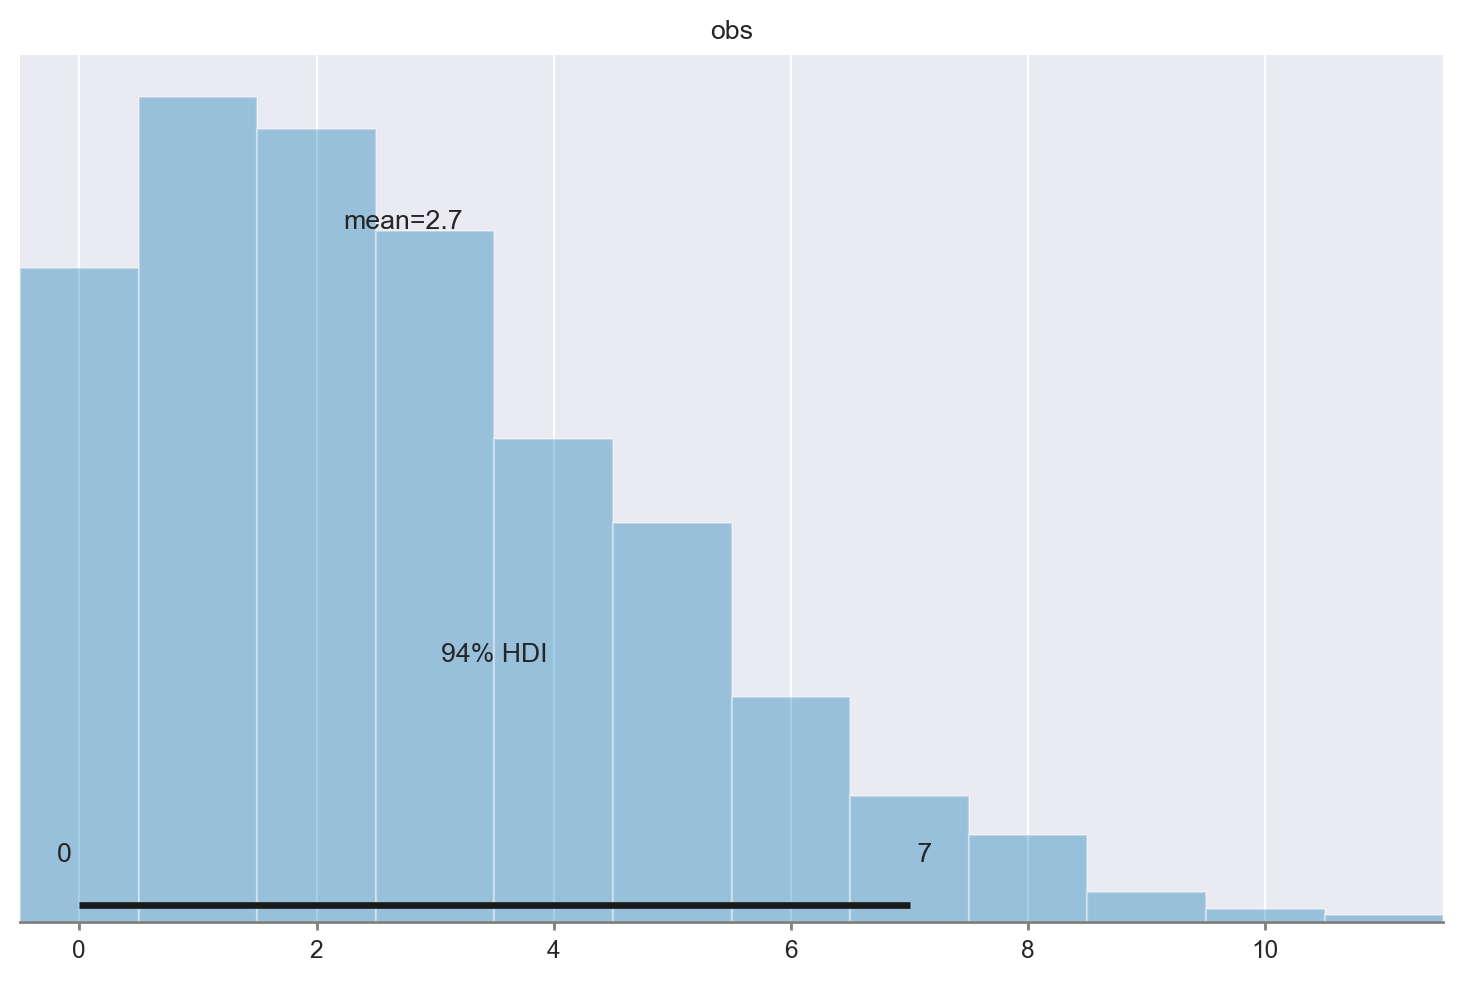

In [15]:
az.plot_posterior(idata.prior_predictive.obs)

La regione HDI al 94% è [0, 6]. Ma noi abbiamo osservato $y$ = 23. Questo ci dice che Beta(2, 10) non è una distribuzione a priori adeguata per i nostri dati.

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat May 06 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

pymc      : 5.3.0
numpy     : 1.23.5
seaborn   : 0.12.2
scipy     : 1.10.1
xarray    : 2023.4.2
matplotlib: 3.7.1
pandas    : 1.5.3
arviz     : 0.15.1

Watermark: 2.3.1

